# Team Information

Project Title: Data Analysis on the Pokémon Pokedex

Team Name: Team 6

Member Names w/ PIDs: Rohan Jaggannagari (rjaggannagari), Jayanth Kalidindi (jayk21), Luke Hylton (lnhylton), Markus Homann (homann), Aniket Sonnakul (anikets)

# Contributions

Rohan Jaggannagari: Cleaned up and merged the datasets from Kaggle, PCA analysis/clustering/distance matrix on legendary Pokemon, correlation matrix for each base stat and generation, wrote code for similarity recomendation system

Jayanth Kalidindi: Helped clean up and merge datasets and helped write/build similarity recommendation system with sliders. 

Luke Hylton: Wrote code and implemented weighted sliders recommedation system, worked on the report and data displays, and helped organize report for answering research questions

Markus Homann: Worked on the report, analysis of Legendary data with respect to similarity between one another, and worked on the PCA analysis/ Clustering 

Aniket Sonnakul: Helped clean dataset and analyze categorical data, and consolidate/write QAC descriptions on report.

# Introduction
The world of Pokemon has been around for decades and has made a large impact on the current school aged generation and continues to do so. There are many aspects to Pokemon from the TV series to the video games to the card game. This card game has a dedicated base of followers who tend to think about Pokemon beyond just the cute forms and their main attacks and look at their statistics. This allows them to develop much more comprehensive team strategies and more. We want to explore these statistics and ask questions that could help further the understanding of Pokemon and their relationships with their types and statistics.

# Research Questions
### 1. What Pokemon have the most similar statistics?
### 2. What Pokemon fit certain statistics best?
### 3. How do legendary Pokemon cluster depending on the number of clusters?
### 4. Which types of Pokemon correlate with which attributes?
### 5. How do different statistics correlate over different generations?
### 6. Which Legendary Pokemon are most similar to each other?

# Using Data Science to Analyze Pokemon Data

To answer these questions, first we need to define the data collected. The primary dataset consists of each Pokemon from Generations 1-7 with their characteristics.

The different characteristics of Pokemon that we are going to be looking at are: Name, Type1, Type2, Hp, Attack, Defense, Special Attack, Special Defense, Speed, Against Poison, Against Psychic, Against Rock, Against Steel, Against Water, Capture Rate, Experience Growth, Height (M), Percentage Male, Weight (Kg). 

The additional dataset shows each Pokemon’s abilities and how their types match up against other types. 


First, we import several modules that will be used to extract, clean, and visualize the data, and then read in the datasets:

## Imports

In [1]:
import pandas
import numpy
import IPython
import sklearn.metrics.pairwise
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, clear_output

## Reading in data

In [2]:
# Read in the data
pokemon_data_df = pandas.read_csv('pokemon_data.csv')
pokemon_abilities_df = pandas.read_csv('pokemon_abilities.csv')

# Output the shape of the data
print("Shape of first dataset is " + str(pokemon_data_df.shape))
print("Shape of second dataset is " + str(pokemon_abilities_df.shape))

Shape of first dataset is (800, 12)
Shape of second dataset is (801, 41)


The data sets are cleaned for specific cases and then merged into a single dataframe.

## Merge both datasets and then clean them

In [3]:
# Some Pokemon in each dataset were named differently so I fixed it
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Ho-oh', 'Name'] = 'Ho-Oh'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Landorus Therian Forme', 'Name'] = 'Landorus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Tornadus Therian Forme', 'Name'] = 'Tornadus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Thundurus Therian Forme', 'Name'] = 'Thundurus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Hoopa Confined', 'Name'] = 'Hoopa'

# Move the name column to all the way to the left
if "name" in pokemon_abilities_df.columns:
    move_name = pokemon_abilities_df.pop('name')
    pokemon_abilities_df.insert(0, 'Name', move_name)

# Merged the two datasets and now have to clean it up so it is more readable
pokemon_df = pandas.merge(pokemon_data_df, pokemon_abilities_df, on = 'Name', how = 'inner', indicator = True)
pokemon_df = pokemon_df[pokemon_df['_merge'] == 'both']

# We do not care about megas so the data from the second dataset number is better to index by
move_pokedex_number = pokemon_df.pop('pokedex_number')
pokemon_df.insert(0, 'Pokedex Number', move_pokedex_number)

# Gets rid of the columns we are not using and the duplicates
pokemon_df = pokemon_df.drop(['#', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'classfication', 'defense', 'hp', 'japanese_name', 'sp_attack','sp_defense','speed','type1','type2','generation','is_legendary', '_merge'], axis = 1)

# Format the names to be more uniform
pokemon_df.columns = [underscore_rem.replace('_', ' ') for underscore_rem in pokemon_df.columns]
pokemon_df.columns = [caps.title() for caps in pokemon_df.columns]

pokemon_df.head(5)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.0,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.0,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.0,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.5,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.5,2.0,45,1059860,1.1,88.1,19.0


Above, we merged the two datasets and cleaned them so they are uniform. This will make it easier to analyze the data since it is readable. We output the first 5 from the data frame to show how it looks.

Here we have to edit the type matchup data so the multipliers are more intuitive.

In [34]:
multi = pokemon_df.copy()
filterCols = [col for col in pokemon_df.columns if col.startswith('Against')]
multi.loc[:, filterCols] = pokemon_df.loc[:, filterCols].apply(lambda x: 1 / x)
# replace infinite values with 0
multi = multi.replace(numpy.inf, 0.0)
multi.head(5)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,0.5,1.0,1.0,2.0,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,0.5,1.0,1.0,2.0,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,0.5,1.0,1.0,2.0,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,0.5,2.0,0.5,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,0.5,2.0,0.5,45,1059860,1.1,88.1,19.0


# What Pokemon have the most similar statistics?

We want to find a Pokemon that has a high stat in a category that is lacking in the current lineup. This is also useful if we want to find a similar Pokemon to one in our squad but of a different type. For example, let's say you wanted to replace a Pokemon on your team with one that is faster but the other stats remain the same. This recommendation system makes that easy since you will be provided with a list of Pokemon. The second recommendation system is used to weigh specific stats like the Andromeda code we worked with in class. 

## Similarity Sliders

Each slider has a minimum value of 1 and a maximum value of 99 that can be chosen by the user. With the desired traits at their values, the recommendation system will rank Pokemons that are closest to the user’s inputs. We can hypothesize that the Pokemon which are ranked as most similar together will be closer together on a 2D visualization.

In [5]:
# Making the sliders for each stat
generation_slider = widgets.IntSlider(value = 1, min = 1, max = 7, step = 1, description = 'Generation:', description_width = 'auto')
generation_slider.layout.width = '75%'
hp_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'HP:', description_width = 'auto')
hp_slider.layout.width = '75%'
attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Attack:', description_width = 'auto')
attack_slider.layout.width = '75%'
defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Defense:', description_width = 'auto')
defense_slider.layout.width = '75%'
sp_attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Attack:', description_width = 'auto')
sp_attack_slider.layout.width = '75%'
sp_defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Defense:', description_width = 'auto')
sp_defense_slider.layout.width = '75%'
speed_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Speed:', description_width = 'auto')
speed_slider.layout.width = '75%'

print("\n" + "Set the sliders to the desired amount and the code below will output Pokemon that are most similar" + "\n")
print("Note: These values are going to be used as %'s" + "\n" + "\n")
print("Choose a generation from 1 to 6, and choose 7 for all generations")
display(generation_slider, hp_slider, attack_slider, defense_slider, sp_attack_slider, sp_defense_slider, speed_slider)


Set the sliders to the desired amount and the code below will output Pokemon that are most similar

Note: These values are going to be used as %'s


Choose a generation from 1 to 6, and choose 7 for all generations


IntSlider(value=1, description='Generation:', layout=Layout(width='75%'), max=7, min=1)

IntSlider(value=1, description='HP:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Speed:', layout=Layout(width='75%'), max=99, min=1)

The slider will be used to show what you want the specfic stats at.

## Similarity Recomendation System

In [6]:
# Only account for the stats
pokemon_rec = pokemon_df[['Name', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]
pokemon_rec = pokemon_rec.set_index('Name')

if generation_slider.value != 7:
    pokemon_rec = pokemon_rec[pokemon_rec['Generation'] == generation_slider.value]
pokemon_rec = pokemon_rec.drop(['Generation'], axis=1)

# Get all of the maxes for all the stats
hp_max = pokemon_rec['Hp'].max()
attack_max = pokemon_rec['Attack'].max()
defense_max = pokemon_rec['Defense'].max()
sp_attack_max = pokemon_rec['Sp. Atk'].max()
sp_defense_max = pokemon_rec['Sp. Def'].max()
speed_max = pokemon_rec['Speed'].max()

# Based on the slider
hp_value = (hp_slider.value * (hp_max - 1))/100
attack_value = (attack_slider.value * (attack_max - 5))/100
defense_value = (defense_slider.value * (defense_max - 5))/100
sp_attack_value = (sp_attack_slider.value * (sp_attack_max - 10))/100
sp_defense_value = (sp_defense_slider.value * (sp_defense_max - 20))/100
speed_value = (speed_slider.value * (speed_max - 5))/100

# Uses the inputs to find most similar
inputs = numpy.array([hp_value, attack_value, defense_value, sp_attack_value, sp_defense_value, speed_value]).reshape(1, -1)
euc_dist = sklearn.metrics.pairwise.euclidean_distances(pokemon_rec.values, inputs)

# Sorts the dataframe
euc_dist_df = pandas.DataFrame(euc_dist, index = pokemon_rec.index, columns = ['Distance'])
euc_dist_df = euc_dist_df.sort_values('Distance')

rankings = pandas.DataFrame(euc_dist_df.index)
rankings_with_stats = pandas.merge(rankings, pokemon_rec, on = 'Name', how = 'inner')
rankings_with_stats.index.name = "Rankings"
rankings_with_stats.head(15)

,Name,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed
Rankings,,,,,,,
0,Caterpie,45,30,35,20,20,45
1,Weedle,40,35,30,20,20,50
2,Kakuna,45,25,50,25,25,35
3,Metapod,50,20,55,25,25,30
4,Zubat,40,45,35,30,40,55
5,Magikarp,20,10,55,15,20,80
6,Pidgey,40,45,40,35,35,56
7,Rattata,30,56,35,25,35,72
8,Nidoran♂,46,57,40,40,40,50


Above, you will be provided a data frame that finds the closest to what the sliders were set to.

With the recommendation system, I can for example take my Pokemon Weedle which has a HP of 40 and a speed of 50. I want to find another Pokemon that is of similar HP, but a higher speed. By setting my desired sliders in the recommendation system I see that Smeargle is a similar Pokemon with an HP of 55 and a speed of 75, which meets my desired requirements. There are many other applications for this recommendation system as it allows us to find Pokemon based on specific traits that we are looking for with rankings. 

# What Pokemon fit certain statistics best?

## Ability Weights Recomendation System

This system is based off of the Andromeda instructor notes and system that we worked with in class. The code has been changed to just use the sliders and weighting methods without performing MDS or inverse Dimension Reduction. These changes were made as we did not need to graph the data, but simply need to weight stats for each Pokemon and the Andromeda code offered a good base for this use. This helps us answer the question of what Pokemon most suited for the stats that are weighted the heaviest.

### Gather columns and clean data for weighting

In [7]:
pokemon_weights_rec = pokemon_df[['Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_weights_rec = pokemon_weights_rec.set_index(pokemon_df.Name)
pokemon_weights_rec = pokemon_weights_rec.fillna(0).astype("int64")
normalized_pokemon = (pokemon_weights_rec - pokemon_weights_rec.mean()) / pokemon_weights_rec.std()

### Weight the data according the weights recieved in function

We are going to weight the data from 0.00001 to 0.9999. 

In [8]:
def weight_data(dataHD, wts):
    # Normalize the weights to sum to 1
    wts = wts / wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = pandas.DataFrame(dataHD * wts)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    dataHDw['relevance'] = dataHDw.sum(axis=1)
    return dataHDw

min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight
weights = pandas.Series(init_weight, index=normalized_pokemon.columns, name = "Weight")

df_2D = weight_data(normalized_pokemon, weights)

### Create sliders for weighing data according to users preferences

This creates the sliders that are used below.

In [9]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min = min_weight, max = max_weight, step = 0.01, value = value, 
                                       description = label, continuous_update = False, readout_format = '.5f')
                   for (label, value) in wts.iteritems()]
    
    # Make the sliders larger
    for slider in sliders:
        slider.layout.width = '75%'
        
    # Display sliders
    for s in sliders:
        display(s)
        
    create_slider_buttons(sliders)
    return sliders

# Makes the buttons to reset and apply
def create_slider_buttons(sliders):    
    apply_button = widgets.Button(description = 'Apply Slider Weights')
    reset_button = widgets.Button(description =' Reset Weights')
    
    output = widgets.Output()
    with output:
        display()

    # More functions
    def apply_button_clicked(change):
        global weights, df_2D
        weights = pandas.Series([s.value for s in sliders], index=normalized_pokemon.columns, name='Weight')
        df_2D = weight_data(normalized_pokemon, weights)
    
        display_data(df_2D)
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    def display_data(data):
        data = data.sort_values("relevance", ascending = False)
        rankings = pandas.DataFrame(data.index)
        rankings_with_stats = pandas.merge(rankings, pokemon_weights_rec, on = 'Name', how = 'inner')
        rankings_with_stats.index.name = "Rankings"

        # Reoutput the rankings
        with output:
            output.clear_output()
            display(rankings_with_stats.head(10))
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    display(output)
    return apply_button, reset_button

### Creates sliders

In [10]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='Hp', layout=Layout(width='75%'), max=0.9999, mi…

FloatSlider(value=1e-05, continuous_update=False, description='Attack', layout=Layout(width='75%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Defense', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Atk', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Def', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Speed', layout=Layout(width='75%'), max=0.9999,…

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description=' Reset Weights', style=ButtonStyle())

Output()

This recommendation system weights the stats to find Pokemon that fit the highest weighted stats best. For example, if you wanted to find a Pokemon that only cares about Hp and Attack only increase those sliders. And then you will get a data frame that only weights those stats. So if we set HP and attack to the max for unweighted sliders for all generations, the table will be different for the weighted sliders setting HP and attack to the 99th percentile. The number 1 Pokemon in both these cases will be Hariyama and Slaking for unweighted and weighted, respectively. The Hariyama has HP, attack, defense, sp. attack, sp. defense, and speed at 144, 120, 60, 40, 60, and 50 respectively. Meanwhile, the Slaking has stats of 150, 160, 100, 95, 65, and 100 in those categories. 

### Comparing the recommendation systems
Each of the above recommendation systems has its own purpose that it can best be used for as the similarity recommendation system can provide the user with a list of Pokemon that are perfectly tailored to the statistics the user has entered. While the weight recommendation system allows users to choose statistics that they value the most and the system will provide them with a list of Pokemon that best fit those most valued statistics. 

Each system can not fulfill the role of the other and therefore both are useful in answering different questions users may have in regard to Pokemon statistics.

# How do legendary Pokemon cluster depending on the number of clusters?

This question looks into how legendary Pokemon cluster when there is a different amount of clusters.

You can choose the number of clusters wanted.

In [11]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

In [12]:
# Makes a copy of the data from above
legendary_df = pokemon_df.copy()

# Filters based on whether it is legendary or not
legendary_df = legendary_df[legendary_df['Legendary']]

# Only use columns with statistics
legendary_df = legendary_df.iloc[:, [1, 4, 5, 6, 7, 8, 9]]

# Get rid of the index and reset it to the name
legendary_df = legendary_df.reset_index()
legendary_df = legendary_df.drop(['index'], axis = 1)
legendary_df = legendary_df.set_index('Name')

# Normalize the data
legendary_df = (legendary_df - legendary_df.mean())/legendary_df.std()

# Clustering the data into a specfic amount of clusters
specfic_clusters = sklearn.cluster.KMeans(n_clusters = cluster_slider.value)
specfic_clusters.init = legendary_df.iloc[:cluster_slider.value,:]
cluster_df = specfic_clusters.fit_predict(legendary_df)

# Puts the data into a dataframe
clustered_legendary = pandas.DataFrame(cluster_df, columns = ['Cluster'], index = legendary_df.index)
clustered_legendary = clustered_legendary.sort_values('Cluster')

# Dataframe to show size per cluster
cluster_size = numpy.bincount(clustered_legendary['Cluster'])
cluster_total_df = pandas.DataFrame({'Size': cluster_size})
cluster_total_df = cluster_total_df.reset_index().rename(columns={'index': 'Cluster'})

cluster_total_df

C:\Python IDE\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Python IDE\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Cluster,Size
0,0,42


Now we know how big each cluster is and that lets us know the groupings.

<function matplotlib.pyplot.show(close=None, block=None)>

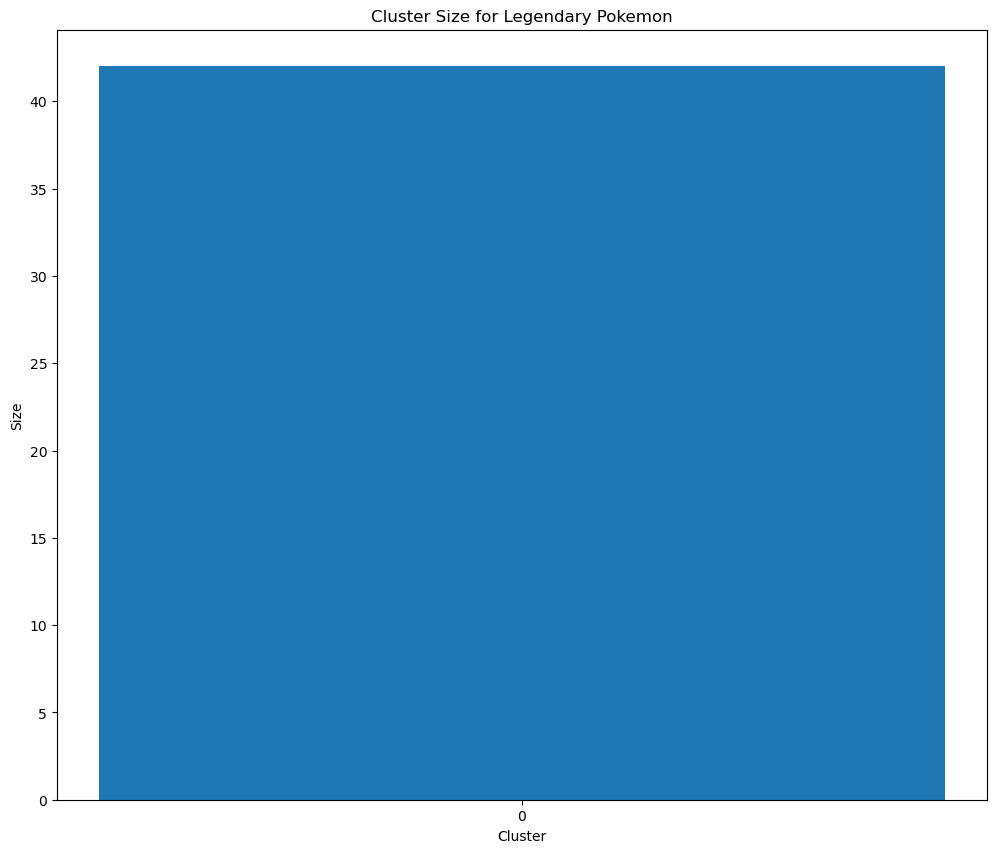

In [13]:
# Bar chart to show cluster size
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(cluster_total_df['Cluster'], cluster_total_df['Size'])
plt.xticks(cluster_total_df.index, cluster_total_df.index)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size for Legendary Pokemon')
plt.show

The graph allows us to see how many legendary Pokemon would be clustered together for different amount of clusters. This can give us useful insight into the average similarity of legendary Pokemon as the clusters increase there are still clusters of legendary Pokemon that have multiple Pokemon showing that some of the legendary Pokemon are very similar such as when the clusters is set to 27 there are 2 clusters of 4 Pokemon each while most of the other clusters are 1-2 Pokemon. This can help show that certain legendary Pokemon are very similar to each other.

# Which types of Pokemon correlate with which attributes?

We can't display a correlation matrix the same way for categorical vs numerical data, but we can see how the averages of a numerical column compare among the types and use this do determine how types match up with certain attributes.

In [14]:
corrTypes = pokemon_df.copy()
typeMean = pokemon_df.groupby('Type 1')['Attack'].mean()
typeMean.head(5)

Type 1
Bug          65.322581
Dark         86.250000
Dragon      102.739130
Electric     67.500000
Fairy        61.529412
Name: Attack, dtype: float64

In [15]:
corrTypes['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

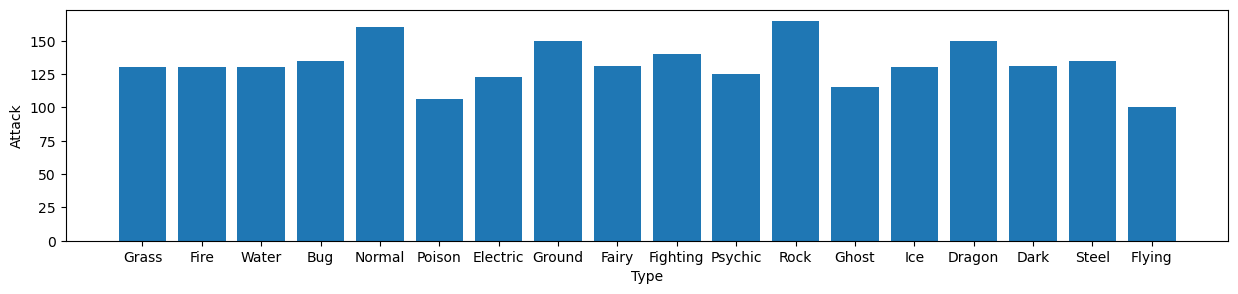

In [16]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Attack'])
plt.xlabel('Type')
plt.ylabel('Attack')
plt.show()

From the distribution, Normal and Rock types have the highest attack on average, while Poison and Flying have the lowest attack.

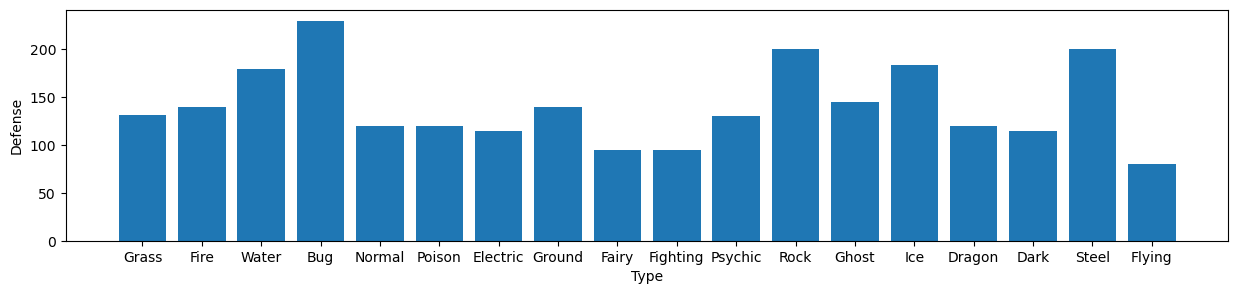

In [17]:
plt.figure(figsize=(15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Defense'])
plt.xlabel('Type')
plt.ylabel('Defense')
plt.show()

Bug, Rock, and Steel have the highest defense on average, while Flying, Fairy, and Fighting have the lowest defense.

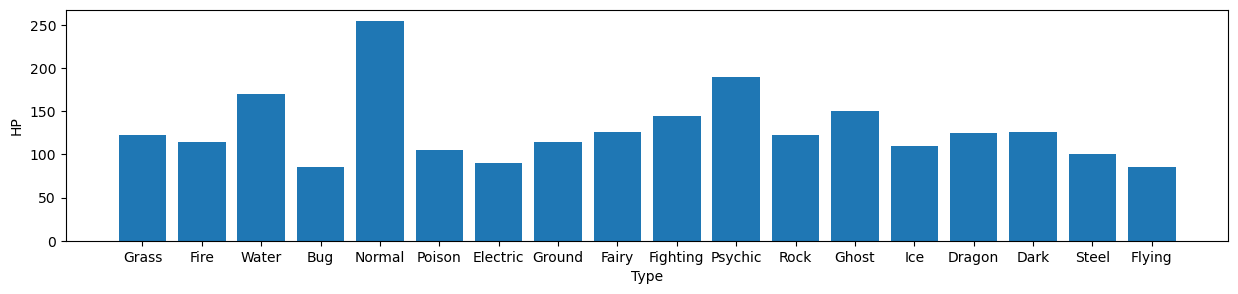

In [18]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Hp'])
plt.xlabel('Type')
plt.ylabel('HP')
plt.show()

For HP, Normal type has the highest by a significant margin while Flying has the lowest. This distribution is much more varied than the others.

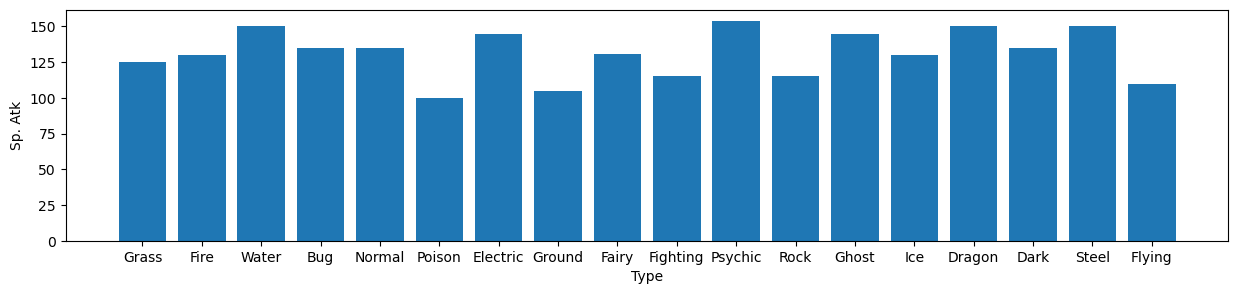

In [19]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Sp. Atk'])
plt.xlabel('Type')
plt.ylabel('Sp. Atk')
plt.show()

For Special Attack, Psychic is the highest though most of the types look to have an average around the same.

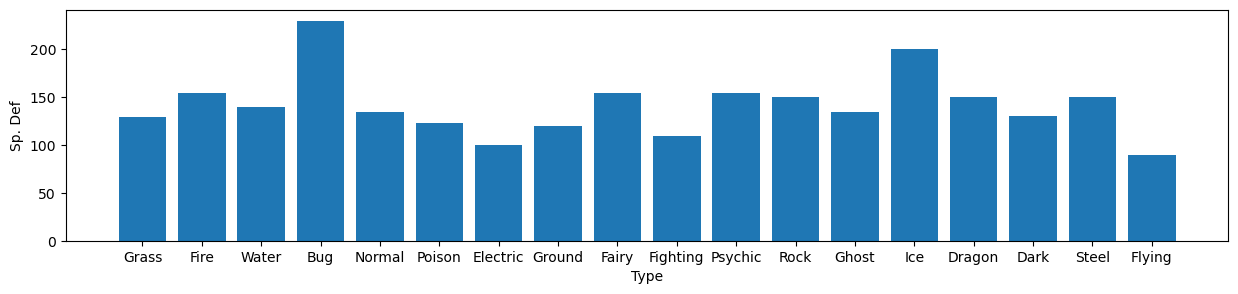

In [20]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Sp. Def'])
plt.xlabel('Type')
plt.ylabel('Sp. Def')
plt.show()

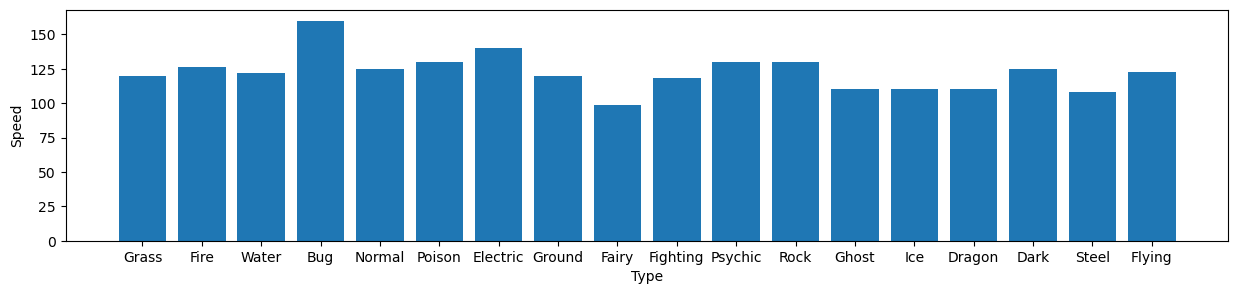

In [21]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Speed'])
plt.xlabel('Type')
plt.ylabel('Speed')
plt.show()

Since we are looking at averages in these distributions, the more significant the margin between stats for a type would likely correlate with that type having a higher stat level. So what we conclude perhaps the best is that you would have a good chance of having a high HP Pokemon with a Normal type. What we do not know however is if outliers are skewing this data and bringing up the mean.

# How do different statistics correlate over different generations?


The slider below will allow you to set it to a specfic generation

In [22]:
gen_slider = widgets.IntSlider(value = 1, min = 1, max = 7, step = 1, description = 'Generation:', description_width='auto')
gen_slider.layout.width = '75%'
print('\n' + 'Note: Choose 7 if you wany to see across generations 1-6')
display(gen_slider)


Note: Choose 7 if you wany to see across generations 1-6


IntSlider(value=1, description='Generation:', layout=Layout(width='75%'), max=7, min=1)

Below, we will look for correlations across different generations or all generations and output them. We have a specific set of stats that we want to look at.

In [23]:
# Create a copy to not mess up previous dataset
generation_df = pokemon_df.copy()

# Only allows Pokemon from that generation
if gen_slider.value != 7:
    generation_df = generation_df[generation_df['Generation'] == gen_slider.value]
generation_corr_stats = generation_df[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
generation_corr_stats = generation_corr_stats.set_index('Name')

# Encode the string
encode_string = LabelEncoder()
generation_corr_stats['Type 1'] = encode_string.fit_transform(generation_corr_stats['Type 1'])
generation_corr_stats['Type 2'] = encode_string.fit_transform(generation_corr_stats['Type 2'])

# Find the correlation matrix
generation_corr_fin = generation_corr_stats.corr()

generation_corr_fin

,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,Height M,Percentage Male,Weight Kg
Type 1,1.000000,0.024093,0.081693,-0.018507,0.231813,-0.040156,-0.004974,-0.044210,0.098026,0.007528,0.132807
Type 2,0.024093,1.000000,-0.125821,-0.120694,-0.068446,-0.105331,-0.056756,0.000172,-0.193547,0.159977,-0.102215
Hp,0.081693,-0.125821,1.000000,0.308086,0.119877,0.236745,0.490993,-0.041251,0.209278,-0.172765,0.459661
Attack,-0.018507,-0.120694,0.308086,1.000000,0.497112,0.149139,0.369606,0.188262,0.314948,0.190680,0.453120
Defense,0.231813,-0.068446,0.119877,0.497112,1.000000,0.187154,0.140306,-0.051434,0.367882,0.089322,0.371335
Sp. Atk,-0.040156,-0.105331,0.236745,0.149139,0.187154,1.000000,0.523340,0.414562,0.106360,0.155327,0.135491
Sp. Def,-0.004974,-0.056756,0.490993,0.369606,0.140306,0.523340,1.000000,0.392870,0.295729,0.151291,0.413309
Speed,-0.044210,0.000172,-0.041251,0.188262,-0.051434,0.414562,0.392870,1.000000,0.242372,0.133731,0.128181
Height M,0.098026,-0.193547,0.209278,0.314948,0.367882,0.106360,0.295729,0.242372,1.000000,-0.037950,0.590757
Percentage Male,0.007528,0.159977,-0.172765,0.190680,0.089322,0.155327,0.151291,0.133731,-0.037950,1.000000,0.093716


Now, we have a data frame that shows how the stats correlate with each other and now we want to visualize it.

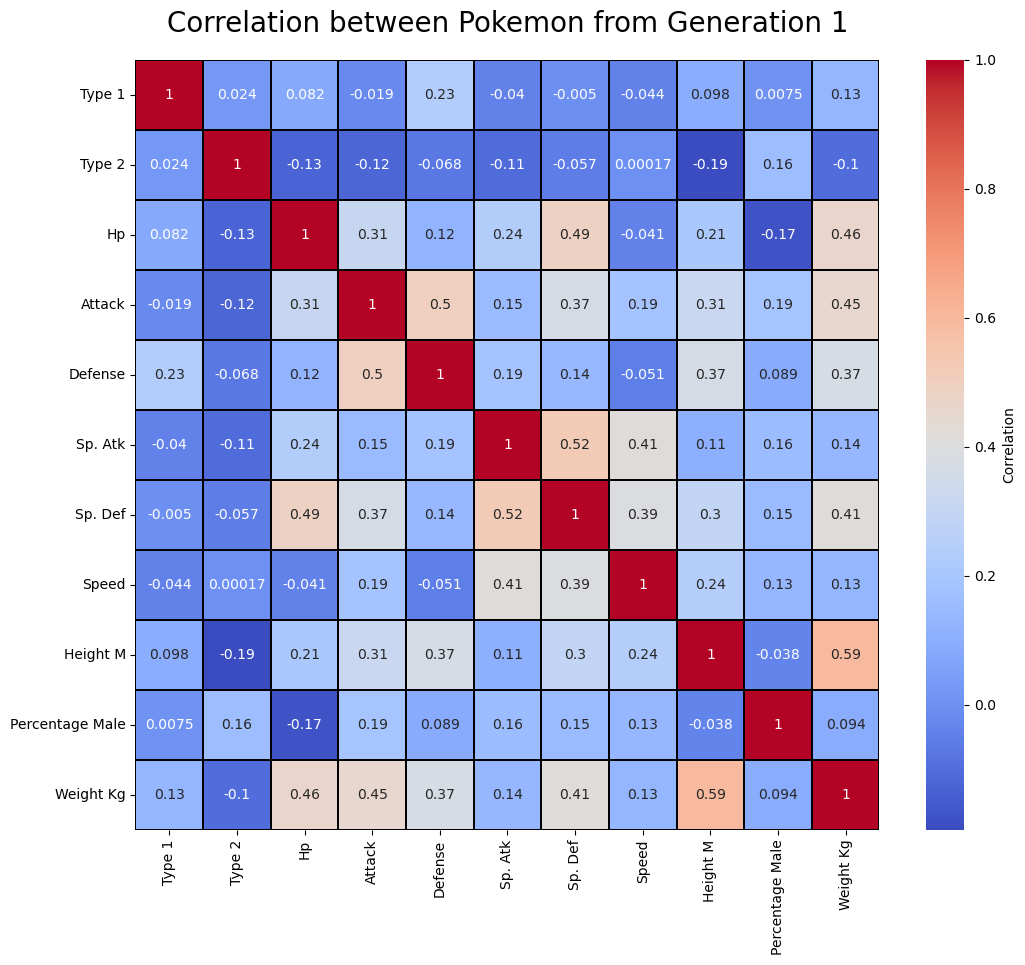

In [24]:
# Graph it
plt.figure(figsize = (12, 10))

if gen_slider.value != 7:
    plt.title('Correlation between Pokemon from Generation ' + str(gen_slider.value), fontsize = 20, pad = 20)
else:
    plt.title('Correlation between Pokemon from Generation 1 - 6', fontsize = 20, pad = 20)
    
sns.heatmap(generation_corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

What we see is that in the first generation, there was not much correlation with the stats, but over more generations that started to change. The stats started to have more and more correlation. So overall, the first few generations did not have much correlation, but the last few had a lot more. For example, in generation 6 there was a strong correlation between height and weight with a value of 0.78. However, in generation 1 the value was only 0.59.

In conclusion, there are correlations between height and weight, special attack and special defense, special defense and defense, weight and attack, and weight and defense.

# Which Legendary Pokemon are most similar to each other?

In [25]:
norm = (legendary_df - legendary_df.mean())/ legendary_df.std()
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(norm)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

numpy.fill_diagonal(euc_dist_matrix.values, numpy.NaN)

Now what if we want to find a Pokemon most similar to a specific Pokemon? We can use the distance matrix that we computed before to see which Pokemon are closest together in. 

In [26]:
similar = pandas.DataFrame(euc_dist_matrix.idxmin())
similar = similar.rename(columns={0: "Most Similar To"})
similar.head(5)

,Most Similar To
Name,
Articuno,Suicune
Zapdos,Moltres
Moltres,Zapdos
Mewtwo,Palkia
Raikou,Latios


As we can see, we have found the most similar Pokemon for each legendary displayed in the table. We can use this information to find a similar legendary Pokemon when trading or swapping out during battle.

In conclusion, we were able to use a normalized Euclidean distance matrix to find the most similar Pokemon in regards to the five stats we have been working with.

## PCA on Legendary Pokemon with Clustering

Now we are going to visualize the similarity of legendary Pokemon using PCA and clustering.

For this part, we are going to do some dimension reduction on the data using PCA. We can hypothesize that points that are closer together on the PCA are more similar in terms of their stats. We can also see if the plotted points are more linear or non-linear, which tells you if the variables within the data are highly correlated or if there may be more complex relationships between the variables.

The first step is to do PCA on the legendary dataset

In [27]:
# Now lets find the location of each legendary Pokemon
pca = sklearn.decomposition.PCA(n_components = 2, svd_solver = 'full')
pca_model_data = pca.fit_transform(legendary_df)
pca_df = pandas.DataFrame(pca_model_data, index = legendary_df.index, columns = ['X', 'Y'])
pca_df = pca_df.sort_index()
pca_df = pca_df.reset_index()

pca_df.head(5)

,Name,X,Y
0,Arceus,-1.062206,0.940334
1,Articuno,1.148798,-0.438500
2,Azelf,-1.664932,-0.792345
3,Cobalion,0.207121,0.647172
4,Darkrai,-0.758820,-1.685392


Next, we will decide the amount of clusters.

In [28]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

Next, we will conduct Kmeans clustering to obtain our clusters.

In [29]:
kmeans = sklearn.cluster.KMeans(n_clusters = cluster_slider.value, n_init = 1, max_iter=10)
labels = kmeans.fit_predict(legendary_df)
labels_DataFrame = pandas.DataFrame(labels, index=legendary_df.index, columns=['Cluster']).sort_values('Cluster')
legendary_df_w_clusters = legendary_df.join(labels_DataFrame).sort_values('Cluster')
legendary_df_w_clusters

C:\Python IDE\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,Cluster
Name,,,,,,,
Articuno,-0.201465,-0.936662,-0.101975,-0.731643,0.608827,-0.462124,0
Heatran,-0.139248,-0.729828,0.127468,0.624619,-0.101471,-0.868600,0
Regigigas,1.042879,2.165847,0.280430,-1.312899,0.048065,0.300018,0
Darkrai,-1.445810,-0.729828,-0.484380,0.818370,-0.699617,1.570254,0
Arceus,1.665052,0.511175,0.662835,0.237115,0.421907,1.316207,0
Victini,0.420707,-0.316160,-0.101975,-0.537892,-0.325776,0.300018,0
Cobalion,-0.139248,-0.729828,1.007000,-0.925395,-1.372532,0.706493,0
Terrakion,-0.139248,0.883476,-0.484380,-1.622901,-0.699617,0.706493,0
Virizion,-0.139248,-0.729828,-1.172709,-0.925395,0.758364,0.706493,0


Now, we will determine the size and max distance of each cluster to aid us in rendering our visualization.

In [30]:
clusters = sorted(list(set(labels)))
sizes = []
max_distances = []
for i in clusters:
    cur_cluster = legendary_df.join(labels_DataFrame)
    cur_cluster = cur_cluster[ cur_cluster['Cluster'] == i ]
    cur_cluster.iloc[:, :-1]
    sizes.append(cur_cluster.shape[0])
    max_distances.append(sklearn.metrics.pairwise.euclidean_distances(cur_cluster.iloc[:, :-1]).max())
    
clusters_df = pandas.DataFrame({'Cluster': clusters, 'Size': sizes, 'MaxDistance': max_distances})
clusters_df

,Cluster,Size,MaxDistance
0,0,42,7.306529


Now, we will obtain the x and y coordinates for each cluster.

In [31]:
tablePCA = pca.transform(kmeans.cluster_centers_)
tablePCA = pandas.DataFrame(tablePCA)
tablePCA.columns = ['X', 'Y']
tablePCA

C:\Python IDE\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,X,Y
0,-1.250565e-17,2.818902e-17


Next, we are ready to display our Pokemon in 2D with clusters, which aim to capture subgroups within the dataset.

C:\Python IDE\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'PCA Dimension Reduction to show Similarity')

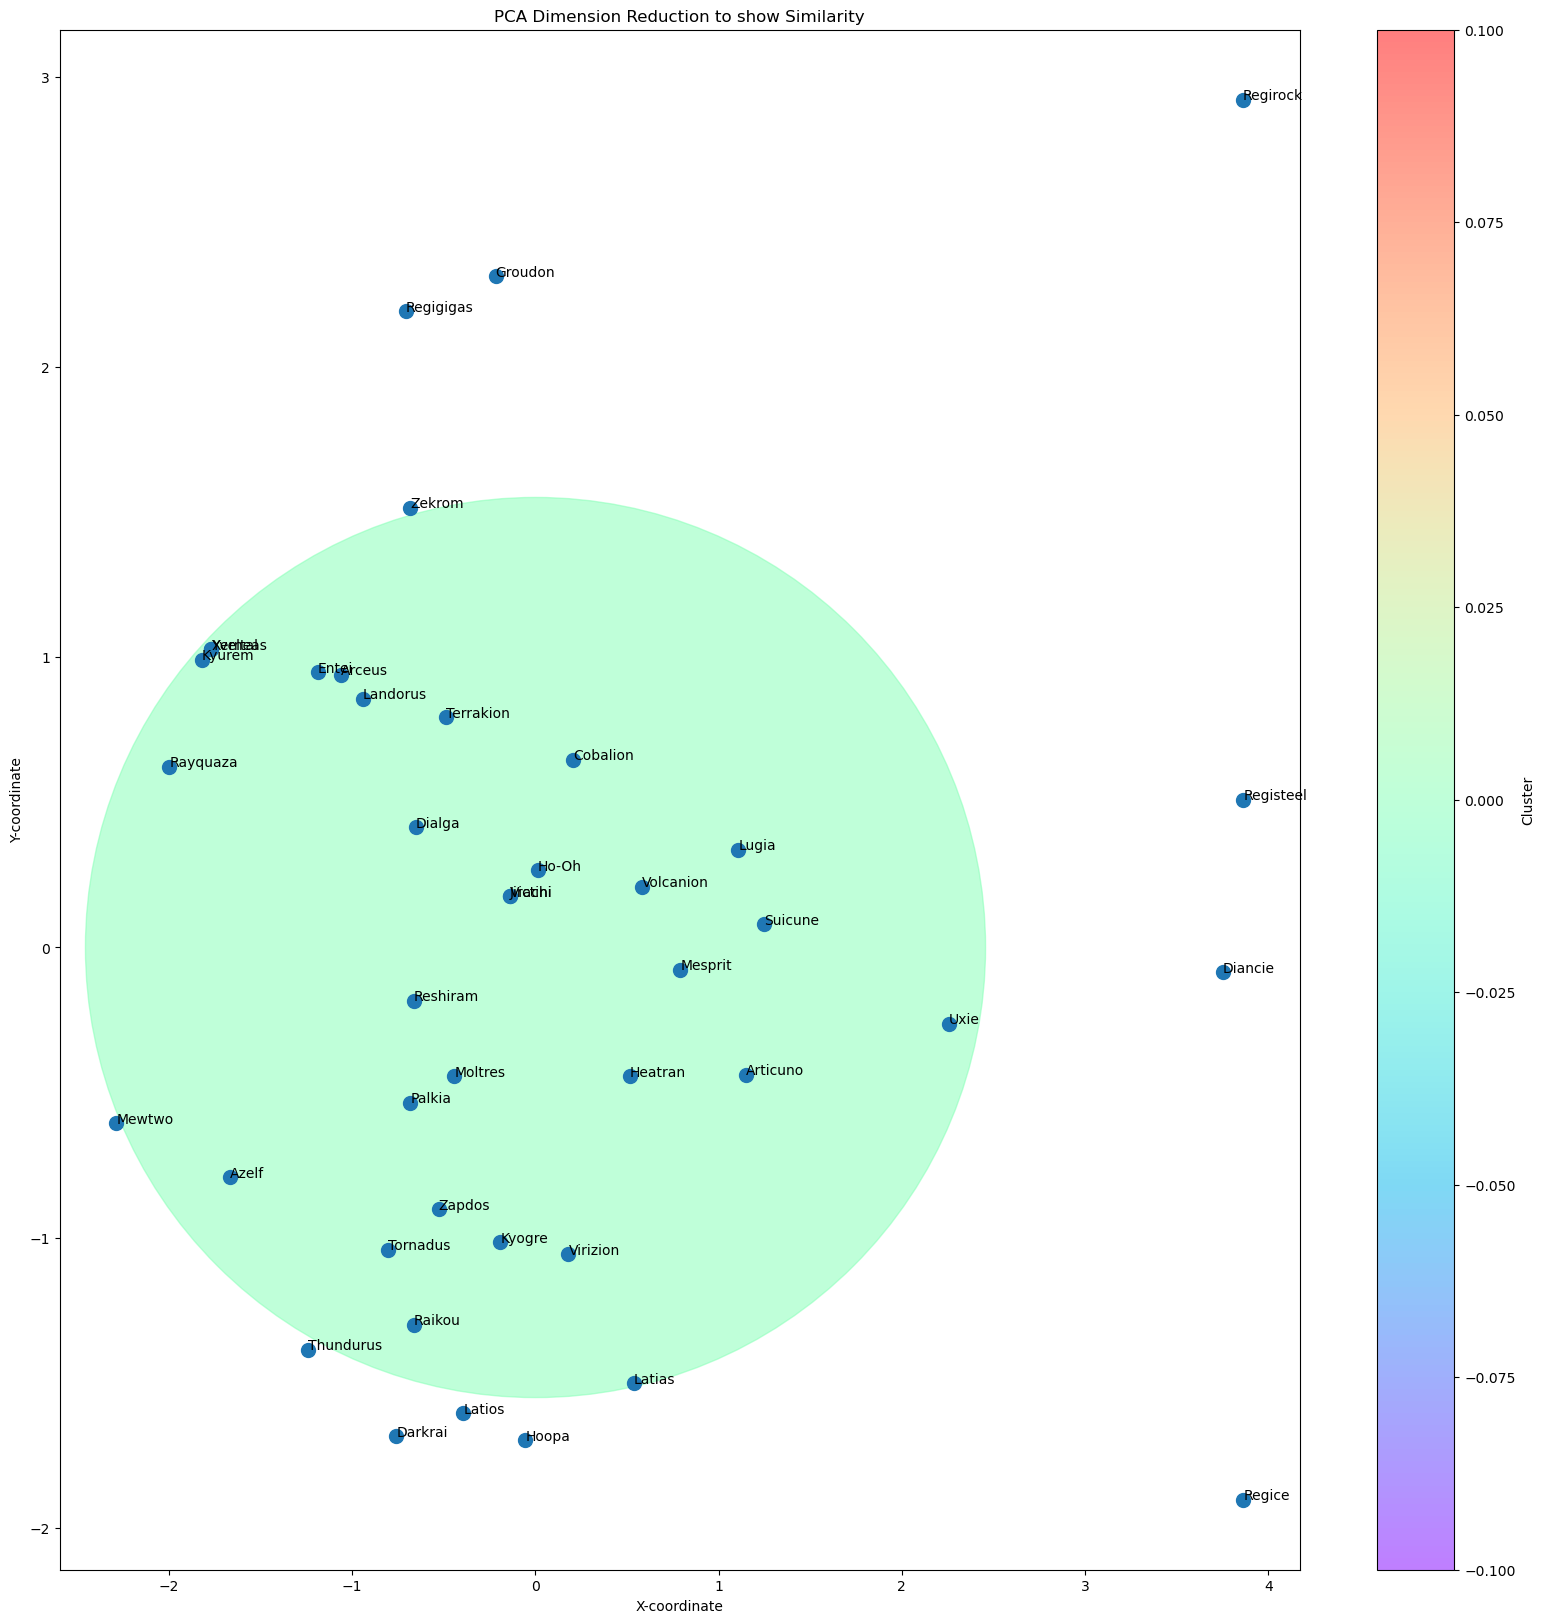

In [32]:
combined = clusters_df.join(tablePCA)
combined
combined['Size'] = combined['Size'].map(lambda s: 10000*s)
ax = combined.plot.scatter('X', 'Y', figsize=(20,20), c='Cluster', s=combined['Size'], alpha=0.5, colormap=plt.cm.rainbow)


pca_df.plot.scatter('X', 'Y', figsize=(20,20), s=100, ax=ax)
for i,r in pca_df.iterrows():
    ax.text(r['X'], r['Y'], pca_df.loc[i, 'Name'])
    
# Labels for the scatter plot
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('PCA Dimension Reduction to show Similarity')

In conclusion, through the addition of clustering, we can group legendary Pokemon with similar attributes and visualize their similarity with the clusters. For example some of the most similar legendary Pokemon being Reshiram, Palkia, and Dialga.